In [40]:
import pandas as pd
from pprint import pprint as pp
from sklearn import preprocessing
%matplotlib inline

# Explorative Data Analysis

# Data Cleaning and Pre-Processing

In [41]:
crowdstorming_df = pd.read_csv('Data/CrowdstormingDataJuly1st.csv')
crowdstorming_df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [42]:
crowdstorming_df.shape

(146028, 28)

In [43]:
#crowdstorming_df.describe()
crowdstorming_df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

From the description, we can conclude the following:
* There are missing values on rater1, rater2 and photoID and since our goal is to build a classifier based on those labels we decided to drop rows with nan values for those columns. 
* There are missing values in height, weight. A tentative solution is to replace those values by average heights and weights of people who belong to the same leagueCountry or people with same position (for e.g: goalkeeper is usually taller), but it is safe to do it and we don't have a lot of missing values. So, we decided to drop them.
* There are missing values for Alpha_3, meanIAT, nIAT, seIAT, meanExp, nExp, seExp. Those we also decided to drop.

In [44]:
crowdstorming_df = crowdstorming_df.dropna()

## Aggregating player-referee information by player

In [45]:
f = {'club':'first',
     'leagueCountry':'first',
     'birthday':'first',
     'height':'first', 
     'weight':'first',
     'games': 'sum', 
     'victories':'sum',
     'ties': 'sum',
     'defeats': 'sum', 
     'goals': 'sum', 
     'yellowCards': 'sum', 
     'yellowReds': 'sum', 
     'redCards': 'sum',
     'photoID':'first',
     'position':'first',
     'refNum':'first',
     'refCountry':'first',
     'Alpha_3':'first',
     'meanIAT':'mean',
     'nIAT':'mean', 
     'seIAT':'mean',
     'meanExp': 'mean',
     'nExp':'mean', 
     'seExp':'mean',
     'rater1':'mean',
     'rater2':'mean'
    }
crowdstorming_df_player_agg = crowdstorming_df.groupby(['playerShort']).agg(f)

# Encoding Categorical to Numerical Values

Since we want to use RandomForest Classifier, we need to convert all columns with categorical values into numerical values. Let's check for the categorical features:

In [46]:
crowdstorming_df_player_agg.dtypes

meanIAT          float64
yellowReds         int64
nExp             float64
photoID           object
leagueCountry     object
refNum             int64
height           float64
rater2           float64
goals              int64
seExp            float64
victories          int64
position          object
games              int64
club              object
birthday          object
seIAT            float64
yellowCards        int64
meanExp          float64
rater1           float64
defeats            int64
weight           float64
nIAT             float64
redCards           int64
ties               int64
Alpha_3           object
refCountry         int64
dtype: object

From the description above, the set of categorical features include:
* club
* leagueCountry
* birthday 
* position 
* Alpha_3

In [47]:
le = preprocessing.LabelEncoder()

crowdstorming_df_num = crowdstorming_df_player_agg 

# Converting club String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['club'])))
crowdstorming_df_num['club'] = le.transform(crowdstorming_df_player_agg['club']) 


# Converting leagueCountry String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['leagueCountry'])))
crowdstorming_df_num['leagueCountry'] = le.transform(crowdstorming_df_player_agg['leagueCountry']) 

# Converting birthday String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['birthday'])))
crowdstorming_df_num['birthday'] = le.transform(crowdstorming_df_player_agg['birthday']) 


# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['position'])))
crowdstorming_df_num['position'] = le.transform(crowdstorming_df_player_agg['position']) 

# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['Alpha_3'])))
crowdstorming_df_num['Alpha_3'] = le.transform(crowdstorming_df_player_agg['Alpha_3']) 

## Binary & Multi-Class Classification Labels

In [48]:
# Averaging over rater1 and rater2: 
crowdstorming_df_num['meanRating'] = (crowdstorming_df_num['rater1'] + crowdstorming_df_num['rater2'])/2
# Create Categories for Binary Classification
def binaryColor(x):
    if x < 0.5: 
        return 0
    else: 
        return 1
crowdstorming_df_num['BinaryColorClass'] = crowdstorming_df_num['meanRating'].apply(binaryColor) 

# Create Categories for Multi Classification
def multiColor(x):
    if x < 0.25: 
        return 0
    elif 0.25 <= x <0.5: 
        return 1
    elif 0.5 <= x < 0.75:
        return 2
    elif 0.75 <= x < 1:
        return 3
crowdstorming_df_num['MultiColorClass'] = crowdstorming_df_num['meanRating'].apply(multiColor) 

In [49]:
features_player = ['weight', 'nExp', 'height', 'meanExp', 'yellowReds',
       'leagueCountry', 'club', 'victories', 'seExp', 'Alpha_3',
       'yellowCards', 'nIAT', 'birthday', 'goals', 'ties',
       'defeats','games','position', 'redCards']
features_referee = ['meanIAT', 'refCountry', 'refNum', 'seIAT']
X = crowdstorming_df_num [features_player]
y_binary = crowdstorming_df_num ['BinaryColorClass']
y_multi = crowdstorming_df_num ['MultiColorClass']

# 1. Supervised Learning

## 1.1. Binary Classification

### Splitting data into train and test

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X,y_binary, test_size=0.3)

In [78]:
# Fit a random forest to the training data for binary classification, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier() # , class_weight='balanced')

forest_binary = forest.fit(X_train, y_train_binary) #, sample_weight= sample_weights)

Let's calculate the accuracy score for train binary classification 

In [79]:
from sklearn import metrics
result_binary_train = forest_binary.predict(X_train)
print(metrics.accuracy_score(y_train_binary, result_binary_train))

0.971802618328


Let's calculate the accuracy score for test binary classification

In [80]:
from sklearn import metrics
result_binary_test = forest_binary.predict(X_test)
print(metrics.accuracy_score(y_test_binary, result_binary_test))

0.786384976526


### K-Fold Cross Validation

In [81]:
from sklearn.cross_validation import cross_val_score
forest_binary = forest.fit(X_train, y_train_binary) #, sample_weight= sample_weights)
scores_binary = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='accuracy')
scores_binary.mean()

0.78718409749275797

## Choosing the prameters of the model

10 trees
score 0.775187293977
30 trees
score 0.794221356508
50 trees
score 0.799865148337
100 trees
score 0.793527120168
200 trees
score 0.803391269603
500 trees
score 0.798461692139
1000 trees
score 0.804794725802
2000 trees
score 0.803386275097


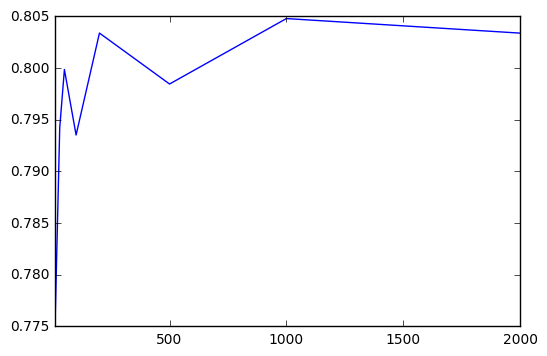

In [87]:
results=[]
n_estimator_options=[10,30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestClassifier(n_estimators=trees)
    scores_binary = cross_val_score(model,  X, y_binary, cv=10, scoring='accuracy')
    print(trees,'trees')
    print('score', scores_binary.mean())
    results.append(scores_binary.mean())
pd.Series(results, n_estimator_options).plot()

1 min_samples
score 0.785745679752
2 min_samples
score 0.796349016082
3 min_samples
score 0.784357207072
4 min_samples
score 0.789301768055
5 min_samples
score 0.789996004395
6 min_samples
score 0.798456697633
7 min_samples
score 0.784357207072
8 min_samples
score 0.792792927779
9 min_samples
score 0.7956198182
10 min_samples
score 0.789996004395


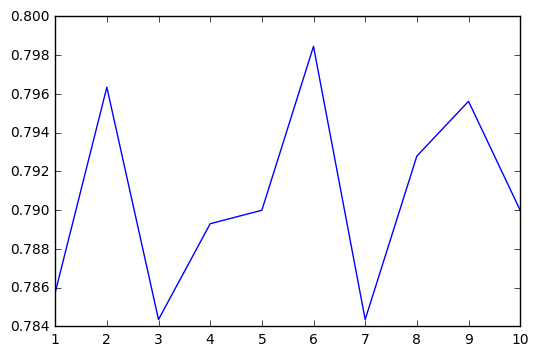

In [89]:
results=[]
min_samples_leaf_options=[1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(min_samples_leaf=min_samples)
    scores_binary = cross_val_score(model,  X, y_binary, cv=10, scoring='accuracy')
    print(min_samples,'min_samples')
    print('score', scores_binary.mean())
    results.append(scores_binary.mean())
pd.Series(results, min_samples_leaf_options).plot()

In [91]:
model = RandomForestClassifier(n_estimators=1000, min_samples_leaf=6)
forest_binary = model.fit(X_train, y_train_binary) #, sample_weight= sample_weights)
scores_binary = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='accuracy')
scores_binary.mean()

0.80197782439316734

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


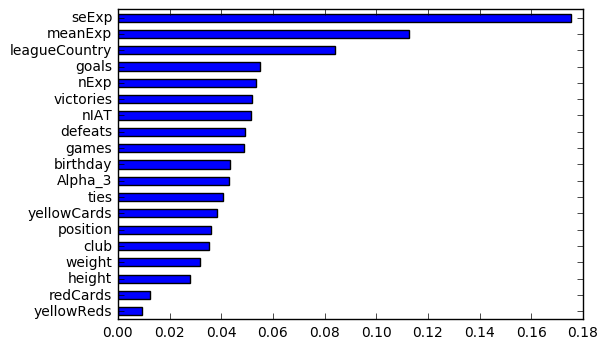

In [93]:
feature_importance= pd.Series(model.feature_importances_,index=X.columns)
feature_importance.sort()
feature_importance.plot(kind='barh')

## Bonus Part

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import numpy as np

In [57]:
def plot_learning_curve(estimator,X,Y,cv=20):
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=np.linspace(0.2,1,20))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r",
            label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

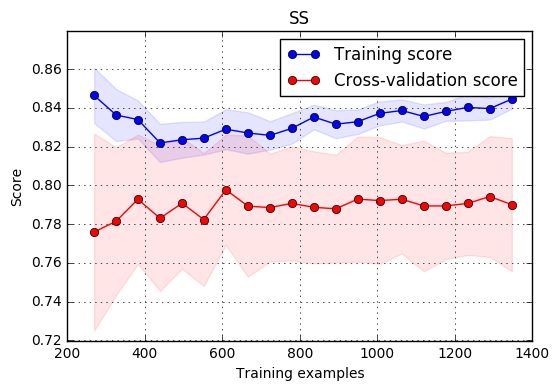

In [61]:
estimator = RandomForestClassifier()    

plot_learning_curve(estimator,X,y_binary)   


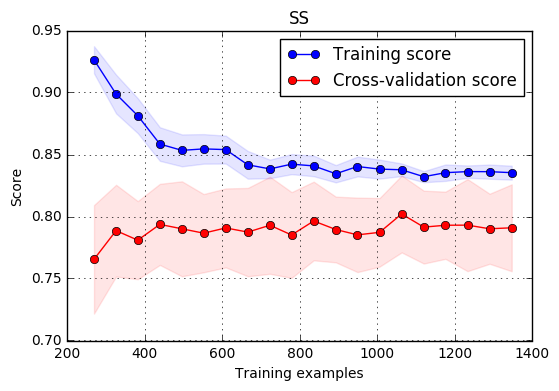

In [60]:
estimator = RandomForestClassifier(max_depth = 6)    
plot_learning_curve(estimator,X,y_binary)   

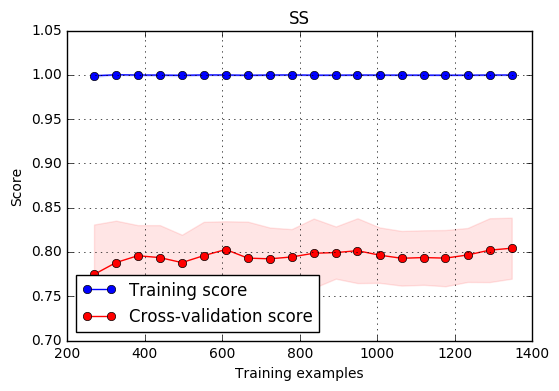

In [63]:
estimator = RandomForestClassifier(n_estimators=50)    
plot_learning_curve(estimator,X,y_binary)   

## 1.2. Multi-Class Classification

### Splitting data into train and test

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_multi, y_test_multi = train_test_split(X,y_multi, test_size=0.3)

In [17]:
# Fit a random forest to the training data for multi-class classification, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

forest_multi = forest.fit(X_train, y_train_multi)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# 2. Unsupervised Learning